In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from pathlib import Path

In [2]:
data_folder = "Cyclone Lab Data 20260209"
project_path = os.path.join(os.getcwd(), data_folder)

# FFT Analysis

In [ ]:
### Load HS Data
HS_file_name = "RawHS.SYN0901019FC1_Fs4000_T300_20260209T164506.csv"

matches = list(Path(project_path).rglob(HS_file_name))

if matches:
    hs_file_path = matches[0]
    print(hs_file_path)
else:
    print("File not found!")
    
HS_df = pd.read_csv(hs_file_path)

cols = [c for c in HS_df.columns if c.startswith("CY_1_T+")]
if not cols:
    print(f"Skipping {HS_file_name}: no CY_1_T+ columns found")

# HS_df_conc = HS_df[cols].stack().reset_index(drop=True).to_frame("CY_1")
HS_df_conc = pd.concat([HS_df[c] for c in cols], ignore_index=True).to_frame("CY_1")
print(f"file: {HS_file_name} - found {len(cols)} CY_1_T+ columns, total {len(HS_df_conc)} rows after stacking")

HS_df_conc #check data head

/home/Xillian/Documents/WEIR/India-test-lab/Cyclone Lab Data 20260209/HS/RawHS.SYN0901019FC1_Fs4000_T300_20260209T164506.csv
file: RawHS.SYN0901019FC1_Fs4000_T300_20260209T164506.csv - found 30 CY_1_T+ columns, total 1200000 rows after stacking


,CY_1
0,-0.00610
1,0.40832
2,0.79772
3,1.09741
4,0.00000
...,...
1199995,-0.04119
1199996,-0.04364
1199997,-0.04302
1199998,-0.04180


Text(0, 0.5, 'HS acceleration magnitude')

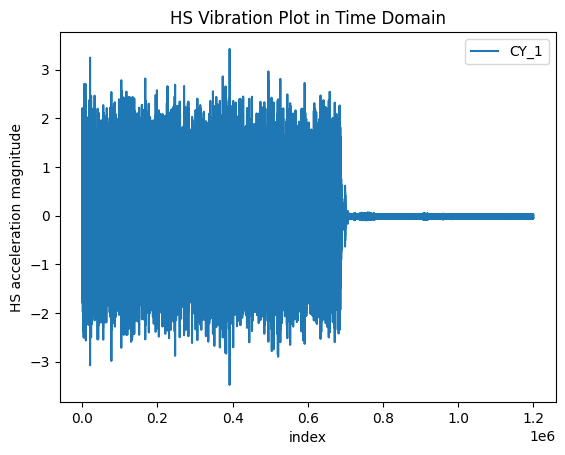

In [13]:
HS_df_conc.plot()
plt.title("HS Vibration Plot in Time Domain")
plt.xlabel("index")
plt.ylabel("HS acceleration magnitude")

# Overall FFT

Sampling rate of HS data: 4000
Length of HS data: 1200000
Total time of HS data: 300.0s


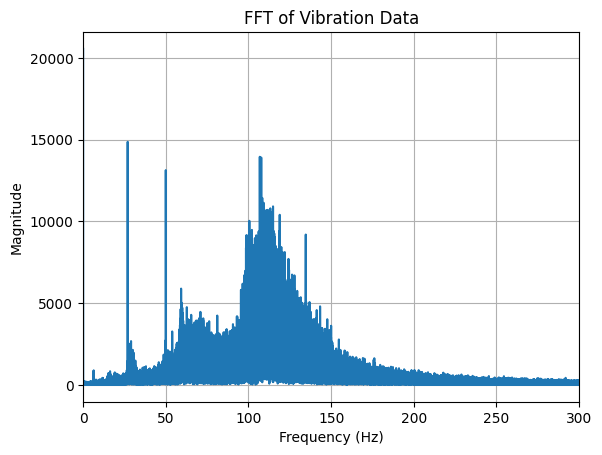

In [ ]:
# Parameters
fs = 4000  # sampling rate in Hz
print(f"Sampling rate of HS data: {fs}")

N = len(HS_df_conc)  # should be ~1.2M points
print(f"Length of HS data: {N}")

T_total = N/fs  # total time in seconds
print(f"Total time of HS data: {T_total}s")

HS_FFT = np.fft.fft(HS_df_conc['CY_1'].values)

fft_magnitude = np.abs(HS_FFT)
 

# Create frequency axis
freq = np.fft.fftfreq(N, d=1/fs)


# For plotting, usually we only care about positive frequencies
positive_freq_idx = freq >= 0
freq_positive = freq[positive_freq_idx]
fft_magnitude_positive = fft_magnitude[positive_freq_idx]


# plt.plot(freq_positive, fft_magnitude_positive)


# Plot
# plt.figure(figsize=(12, 6))
plt.plot(freq_positive, fft_magnitude_positive)
plt.xlim(0, 300)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of Vibration Data')
plt.grid(True)
plt.show()

# Spectrogram

Total duration : 300s | Windows: 300 | Freq bins: 2001


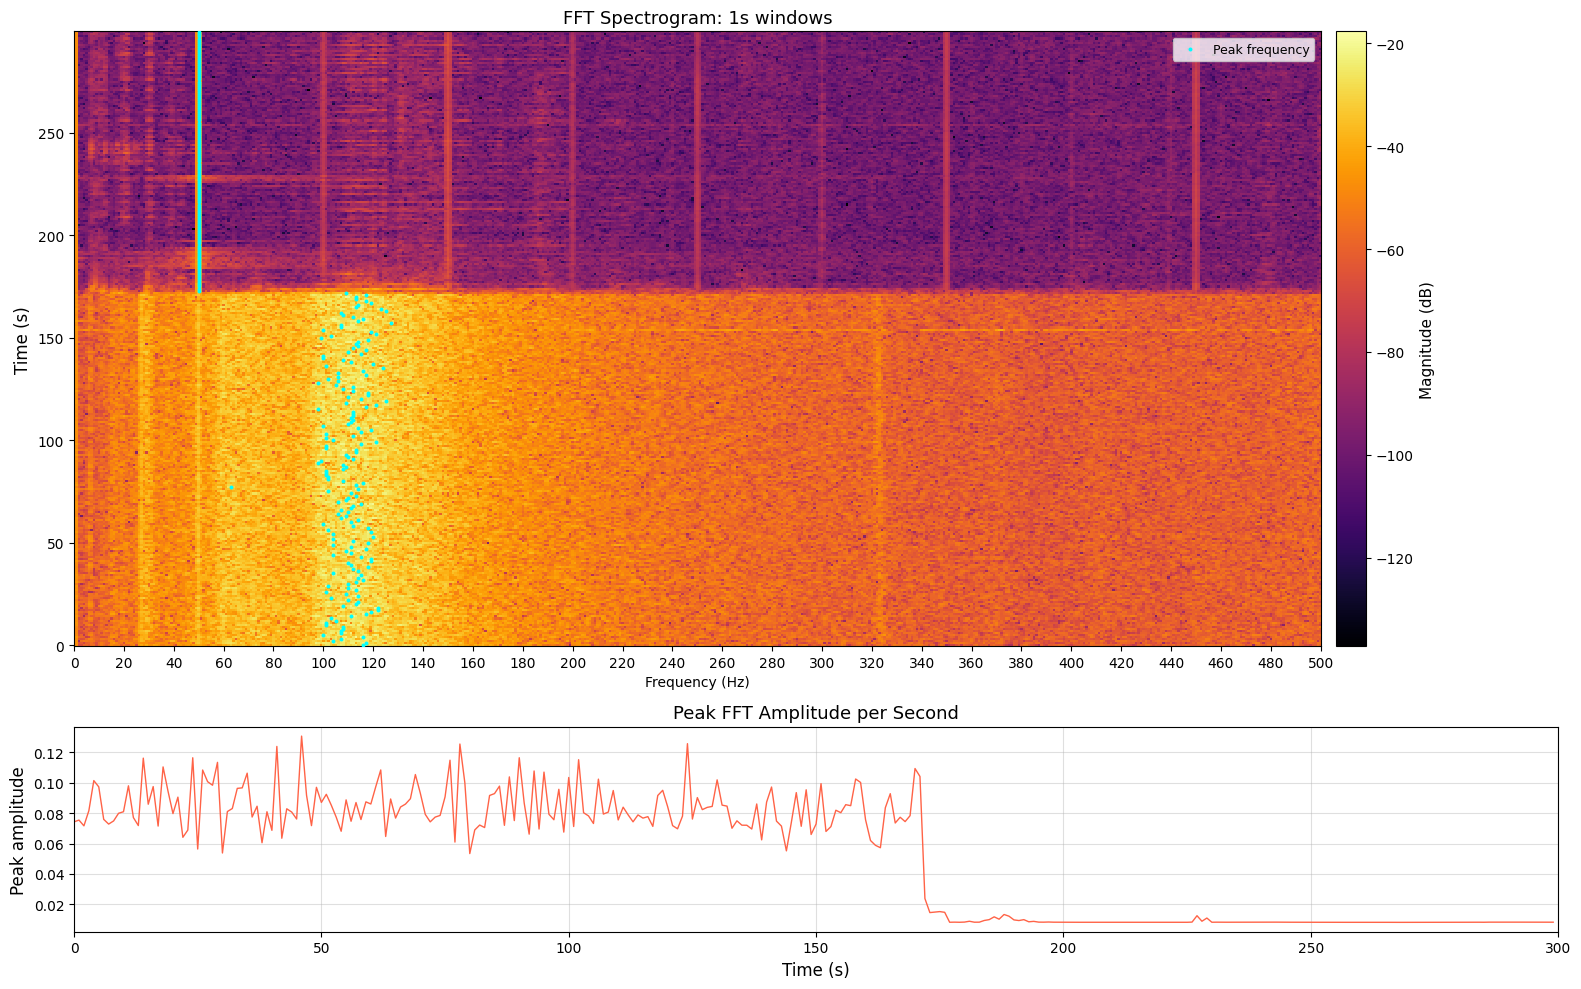

     second  peak_freq_hz  peak_amplitude
0         0         116.0        0.074276
1         1         117.0        0.075436
2         2         104.0        0.071639
3         3         107.0        0.081634
4         4         116.0        0.101408
..      ...           ...             ...
295     295          50.0        0.008294
296     296          50.0        0.008287
297     297          50.0        0.008308
298     298          50.0        0.008274
299     299          50.0        0.008280

[300 rows x 3 columns]


In [18]:
# ── Parameters ────────────────────────────────────────────────────────────────
fs               = 4000          # Hz
samples_per_sec  = fs            # 4000 samples per 1-second window
N_total          = len(HS_df_conc)
n_seconds        = int(N_total / samples_per_sec)
n_freqs          = samples_per_sec // 2 + 1  # positive frequencies only

USE_DB           = True          # False → linear magnitude
FREQ_MAX         = 500          # Hz — crop x-axis (None = full Nyquist)

print(f"Total duration : {n_seconds}s | Windows: {n_seconds} | Freq bins: {n_freqs}")

# ── Build FFT matrix (time × frequency) ───────────────────────────────────────
fft_matrix  = np.zeros((n_seconds, n_freqs))
peak_freqs  = np.zeros(n_seconds)
peak_amps   = np.zeros(n_seconds)

signal = HS_df_conc['CY_1'].values

for t in range(n_seconds):
    start = t * samples_per_sec
    end   = start + samples_per_sec

    window  = signal[start:end]
    N       = len(window)

    # Apply Hann window to reduce spectral leakage
    hann    = np.hanning(N)
    fft_out = np.fft.rfft(window * hann)          # rfft gives positive freqs only
    mag     = np.abs(fft_out) / N                 # normalise by window length

    fft_matrix[t, :] = mag

    # Peak (ignore DC component at bin 0)
    peak_bin       = np.argmax(mag[1:]) + 1
    peak_freqs[t]  = peak_bin * (fs / N)
    peak_amps[t]   = mag[peak_bin]

# ── Frequency axis ─────────────────────────────────────────────────────────────
freq_axis = np.fft.rfftfreq(samples_per_sec, d=1/fs)  # shape: (n_freqs,)

# Crop to FREQ_MAX if set
if FREQ_MAX is not None:
    freq_mask  = freq_axis <= FREQ_MAX
    freq_plot  = freq_axis[freq_mask]
    mat_plot   = fft_matrix[:, freq_mask]
else:
    freq_plot  = freq_axis
    mat_plot   = fft_matrix

# Convert to dB if requested
if USE_DB:
    mat_plot = 20 * np.log10(mat_plot + 1e-12)   # +epsilon avoids log(0)
    cbar_label = 'Magnitude (dB)'
else:
    cbar_label = 'Magnitude'

# ── Plot 1: Spectrogram heatmap ───────────────────────────────────────────────
fig, axes = plt.subplots(2, 1, figsize=(16, 10),
                         gridspec_kw={'height_ratios': [3, 1]},
                         sharex=False)

# Heatmap
ax = axes[0]
im = ax.pcolormesh(
    freq_plot,
    np.arange(n_seconds),
    mat_plot,
    shading='auto',
    cmap='inferno'
)
cbar = fig.colorbar(im, ax=ax, pad=0.01)
cbar.set_label(cbar_label, fontsize=11)

# Overlay peak frequency per second as a scatter
ax.scatter(peak_freqs, np.arange(n_seconds),
           color='cyan', s=8, linewidths=0, label='Peak frequency', zorder=3)

ax.set_ylabel('Time (s)', fontsize=12)
ax.set_xlabel('Frequency (Hz)')
ax.set_title('FFT Spectrogram: 1s windows', fontsize=13)
ax.legend(loc='upper right', fontsize=9)
ax.set_xlim(0, freq_plot[-1])

# ── Plot 2: Peak amplitude over time ─────────────────────────────────────────
ax2 = axes[1]
ax2.plot(np.arange(n_seconds), peak_amps, color='tomato', linewidth=1)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Peak amplitude', fontsize=12)
ax2.set_title('Peak FFT Amplitude per Second', fontsize=13)
ax2.grid(True, alpha=0.4)
ax2.set_xlim(0, n_seconds)
ax.set_xticks(np.arange(0, FREQ_MAX + 1, 20))   # tick every 50 Hz

plt.tight_layout()
plt.show()

# ── Summary table ─────────────────────────────────────────────────────────────
peak_df = pd.DataFrame({
    'second'        : np.arange(n_seconds),
    'peak_freq_hz'  : peak_freqs.round(2),
    'peak_amplitude': peak_amps
})
print(peak_df)

# Optional: save
# peak_df.to_csv('peak_fft_per_second.csv', index=False)

# FFT Sanity Checks

Text(0.5, 1.0, 'FFT of 50 Hz Sine Wave')

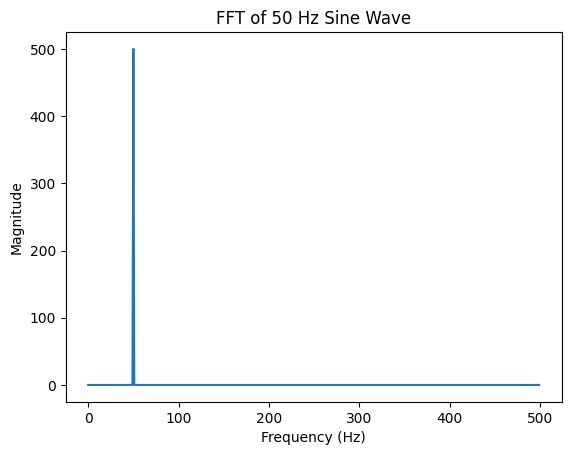

In [7]:
import numpy as np
from scipy.fft import fft, fftfreq

fs = 1000       # sampling rate in Hz
t = np.linspace(0, 1, fs, endpoint=False)
x = np.sin(2*np.pi*50*t)  # 50 Hz sine wave

Y = fft(x)
freqs = fftfreq(len(x), 1/fs)

fig, ax = plt.subplots()
ax.plot(freqs[:len(freqs)//2], np.abs(Y)[:len(Y)//2])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_title('FFT of 50 Hz Sine Wave')